#import libraries

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import get_file
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


In [7]:
# import csv file
df1 = pd.read_csv('yelp_reviews.csv', nrows=100000)

In [8]:
df1.shape

(100000, 9)

#data cleaning

In [9]:
df1.head(6)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
5,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31


In [10]:
df2 = df1.drop(['review_id','user_id','business_id','useful','funny','cool','date'] ,axis=1 , inplace=False)

In [11]:
df2.head(6)

,stars,text
0,3.0,"If you decide to eat here, just be aware it is..."
1,5.0,I've taken a lot of spin classes over the year...
2,3.0,Family diner. Had the buffet. Eclectic assortm...
3,5.0,"Wow! Yummy, different, delicious. Our favo..."
4,4.0,Cute interior and owner (?) gave us tour of up...
5,1.0,I am a long term frequent customer of this est...


In [12]:
# checking null values
df2.isnull().sum()

stars    0
text     0
dtype: int64

In [13]:
#checking duplicates
df2.duplicated().sum()

34

In [14]:
#Removing duplicates
df3 = df2.drop_duplicates(inplace=False)

In [15]:
df3.duplicated().sum()

0

In [16]:
df3.head(6)

,stars,text
0,3.0,"If you decide to eat here, just be aware it is..."
1,5.0,I've taken a lot of spin classes over the year...
2,3.0,Family diner. Had the buffet. Eclectic assortm...
3,5.0,"Wow! Yummy, different, delicious. Our favo..."
4,4.0,Cute interior and owner (?) gave us tour of up...
5,1.0,I am a long term frequent customer of this est...


<Axes: title={'center': 'Review Stars'}, xlabel='stars'>

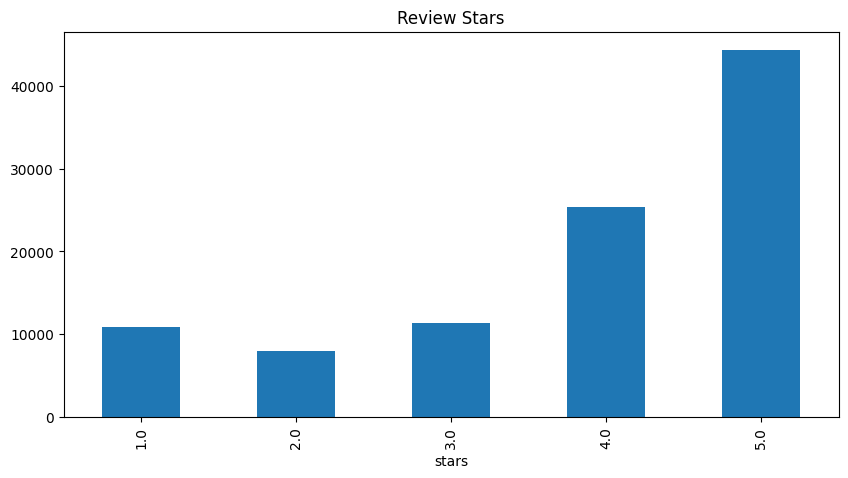

In [17]:
df3['stars'].value_counts().sort_index().plot(kind='bar', title="Review Stars", figsize=(10,5))

#dividing starts into negative neutral positive

In [18]:
# 0 - negative
# 1 - neutral
# 2 - positive

# Function to convert score to sentiment
def sentiment(rating):
    
    rating = int(rating)
    # Convert to class
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

# Apply to the dataset 
df3['sentiment'] = df3['stars'].apply(sentiment)

C:\Users\Genuka K Manthila\AppData\Local\Temp\ipykernel_31232\4007003634.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['sentiment'] = df3['stars'].apply(sentiment)


In [19]:
df3.head(5)

,stars,text,sentiment
0,3.0,"If you decide to eat here, just be aware it is...",1
1,5.0,I've taken a lot of spin classes over the year...,2
2,3.0,Family diner. Had the buffet. Eclectic assortm...,1
3,5.0,"Wow! Yummy, different, delicious. Our favo...",2
4,4.0,Cute interior and owner (?) gave us tour of up...,2


In [20]:
# checking new sentiment values
df3['sentiment'].value_counts().sort_index()

sentiment
0    18902
1    11361
2    69703
Name: count, dtype: int64

In [21]:
# taking sample data set
df4=df3.iloc[:100000]
df4

,stars,text,sentiment
0,3.0,"If you decide to eat here, just be aware it is...",1
1,5.0,I've taken a lot of spin classes over the year...,2
2,3.0,Family diner. Had the buffet. Eclectic assortm...,1
3,5.0,"Wow! Yummy, different, delicious. Our favo...",2
4,4.0,Cute interior and owner (?) gave us tour of up...,2
...,...,...,...
99995,4.0,Came here for lunch with a group. They were bu...,2
99996,1.0,The equipment is so old and so felty! I just u...,0
99997,4.0,This is one of my favorite Mexican restaurants...,2
99998,2.0,Came here for brunch - had an omlette ($19 + t...,0


In [22]:
df4['sentiment'].value_counts().sort_index()

sentiment
0    18902
1    11361
2    69703
Name: count, dtype: int64

#fixing data imbalancing using oversampling technique

In [23]:
# here we used over sampling technique to fix data imbalace issue
count_class_2, count_class_0 , count_class_1 = df4.sentiment.value_counts()

df_class_0 = df4[df4['sentiment'] == 0]
df_class_1 = df4[df4['sentiment'] == 1]
df_class_2 = df4[df4['sentiment'] == 2]

In [24]:
count_class_2 , count_class_0, count_class_1 

(69703, 18902, 11361)

In [25]:
df_class_2.shape

(69703, 3)

In [26]:
df_class_1.shape

(11361, 3)

In [27]:
df_class_0.shape

(18902, 3)

In [28]:
# Adding sample data
df_class_0_over = df_class_0.sample(count_class_2, replace=True)
df_class_1_over = df_class_1.sample(count_class_2, replace=True)

In [29]:
df_class_0_over.shape , df_class_1_over.shape

((69703, 3), (69703, 3))

In [30]:
# concatanating new values into dataframe
df4 = pd.concat([df_class_2,df_class_1_over,df_class_0_over], axis=0)

In [31]:
df4['sentiment'].value_counts().sort_index()

sentiment
0    69703
1    69703
2    69703
Name: count, dtype: int64

#data preprocessing

In [33]:
# data preprocessing using nltk 
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to C:\Users\Genuka K
[nltk_data]     Manthila\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Genuka K
[nltk_data]     Manthila\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [34]:
# create a function to do preprocessing part
def clean_text_nltk(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and digits using regex
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I | re.A)
    # Tokenize using NLTK
    words = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

In [35]:
x = df4['text'].apply(clean_text_nltk)
y = df4['sentiment']

In [36]:
X = []

for sen in x:
  X.append(sen)


In [38]:
Y = y.to_numpy()


In [39]:
Y[6]

2

In [40]:
X[6]

'locals recommended milktooth amazing jewel indianapolis im glade chance experience'

In [41]:
#spliting data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


In [42]:
X_train[6]

'good pizza thats little higher average definitely wont disappointed scicilian way go want best'

In [43]:
y_train

array([2, 1, 2, ..., 1, 0, 1], dtype=int64)

In [44]:
max_words = 5000
max_len = 100

In [45]:
# tokenazation part
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [46]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [47]:
vocab_length = len(tokenizer.word_index) + 1

vocab_length

84669

In [48]:
X_train_pad = pad_sequences(X_train_seq,padding='post', maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq,padding='post' , maxlen=max_len)

#embedding

In [49]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [50]:
# Create Embedding Matrix having 100 columns 
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [51]:

embedding_matrix.shape

(84669, 100)

In [53]:
len(embedding_matrix)

84669

#Model training

In [54]:
# Neural Network architecture
model = Sequential()
model.add(Embedding(input_dim=len(embedding_matrix), output_dim=100, input_length=max_len, weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

In [55]:

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          8466900   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 256)         234496    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 100, 256)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 3)                

Trainable params: 399,235
Non-trainable params: 8,466,900
_________________________________________________________________
None


In [2]:
# model traing part
lstm_model_history = model.fit(X_train_pad, y_train, batch_size=32, epochs=10, verbose=1, validation_split=0.2)


NameError: name 'model' is not defined

#Model evaluation

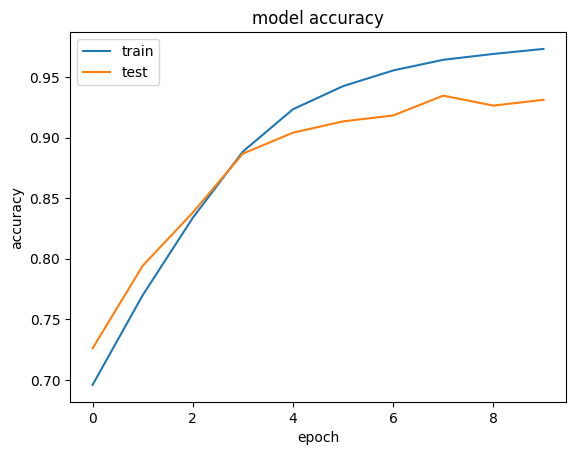

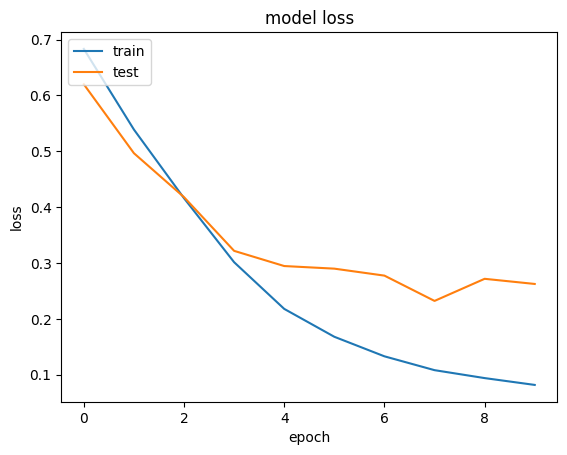

In [62]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [6]:
#saving the model
from keras.models import load_model 
model.save("saved_model.h5") 

NameError: name 'model' is not defined

In [7]:
# loading saved model
loaded_model = load_model("saved_model.h5") 

In [8]:
# Model evaluation classification report
y_pred_probs = loaded_model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)

# Print accuracy and classification report
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print('\nClassification Report:\n', classification_report(y_test, y_pred))

NameError: name 'X_test_pad' is not defined

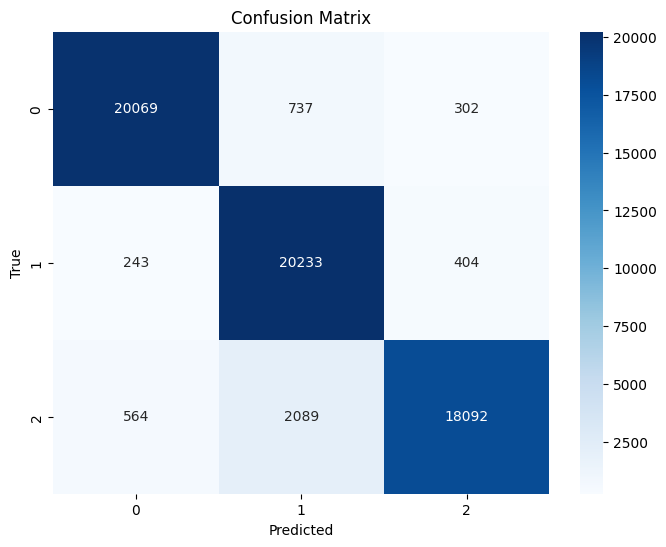

In [61]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()